# TSSaliencyExplainer For Multivariate

Time Series Saliency (TSSaliency) Explainer is a model agnostic saliency explainer for time series associate tasks. The saliency supports univariate and multivariate use cases. It explains temporal importance of different variates on the model prediction. TSSaliency incorporates an integrated gradient method for saliency estimation and, therefore, provides reasonable values for functions that are continuous, and differentiable almost everywhere. It may be ill-suited to certain types of ensemble models such as Random Forests. The saliency measure involves the notion of a base value. For example, the base value can be the constant signal with average value. The saliency measure is computed by integrating the model sensitivity over a trajectory from the base value to the time series signal. The TSSaliency explainer provides variate wise contributions to model prediction at a temporal resolution.

This notebook demonstrates usage of TSSaliencyExplainer for Multi-variate data using [Jena Climate dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by Max Planck Institute for Biogeochemistry.

<a id='notebook_workflow'></a>
## Notebook Workflow
- [Imports](#imports)
- [Load Dataset](#load_dataset)
- [Train Forecaster](#train_forecaster)
- [Initialize TSSaliencyExplainer](#initialize_tssaliency)
- [Compute Explanation](#compute_explanation)
- [Plot Explanation](#plot_explanation)

<a id='imports'></a>
### Imports

The example model is a pre-trained keras model and hosted on huggingface hub. So, this notebook requires to install tensorflow 2.4+ and huggingface_hub packages.

In [ ]:
!pip install huggingface_hub

In [1]:
import os
# to suppress unrelated tensorflow warnings while importing aix360.datasets
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from huggingface_hub import from_pretrained_keras
from aix360.datasets import ClimateDataset
from aix360.algorithms.tsutils.tsframe import tsFrame
from aix360.algorithms.tssaliency.tssaliency import TSSaliencyExplainer
from aix360.algorithms.tsutils.model_wrappers import Tensor_Based_Forecaster
from huggingface_hub.utils import logging as h_logging

# huggingface hub warnings
h_logging.set_verbosity_error()


<a id='load_dataset'></a>
### Load Dataset

The dataset is weather readings recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany from 2009 to 2016. It can be obtained from [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/), [Keras examples](https://github.com/keras-team/keras-io/blob/master/examples/timeseries/timeseries_weather_forecasting.py) or [Kaggle](https://www.kaggle.com/stytch16/jena-climate-2009-2016).

As described in the prior links, the dataset consists of 14 variables (temperature, pressure etc.) measured every 10 minutes. The data is aggregated for an hour for analysis. The pre-trained model used in this notebook, is trained on selected (7) features with 120 hours as past window and forecasts temperature after 12 hours in Celcius. More details on dataset are available in [Keras examples](https://github.com/keras-team/keras-io/blob/master/examples/timeseries/timeseries_weather_forecasting.py)


In [2]:
datasets = ClimateDataset().load_data(return_train=False, test_start=100551)

In [3]:
df = datasets["df"]
selected_feature_columns = datasets["selected_feature_columns"]
selected_feature_names = datasets["selected_feature_names"]
sequence_length = datasets["sequence_length"]
x_test = datasets["x_test"]
y_test = datasets["y_test"]
timestamps = datasets["timestamps"]

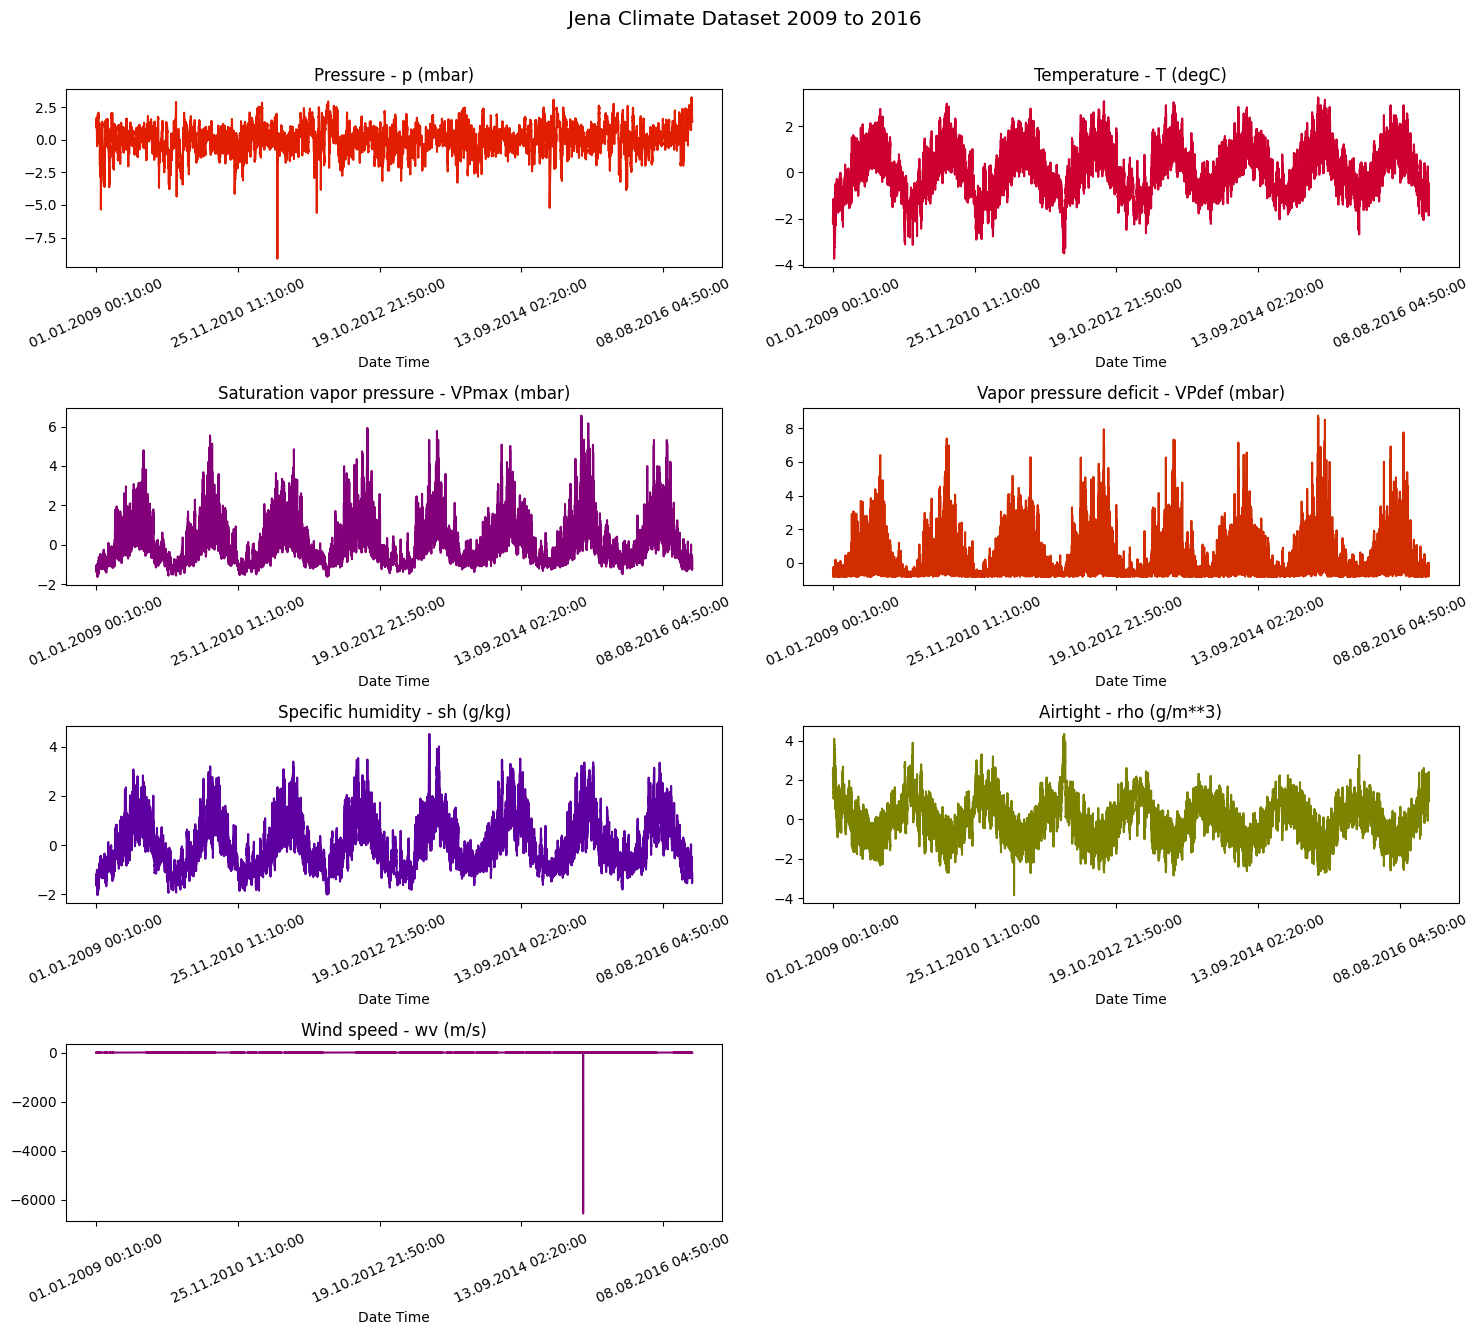

In [4]:
import matplotlib

np.random.seed(242)
cmap = matplotlib.cm.brg
colors = cmap(np.random.choice(np.arange(256), len(selected_feature_columns)))

fig = plt.figure(figsize=(15,14))

for i, feature_col in enumerate(selected_feature_columns):
    feature_data = df[feature_col]
    feature_data.index = timestamps
    ax = fig.add_subplot(int((len(selected_feature_columns) + 1) / 2), 2, i+1)
    ax = feature_data.plot(
        ax=ax,
        color=colors[i],
        title="{} - {}".format(selected_feature_names[i], feature_col),
        rot=25,
    )
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle("Jena Climate Dataset 2009 to 2016", fontsize="x-large")
plt.show()

<a id='train_forecaster'></a>
### Download Pre-Trained Model
For simplicity, use a pre-trained model from Keras/HuggingFace.

The pre-trained model is from: https://keras.io/examples/timeseries/timeseries_weather_forecasting/
The Hugging face model url is: https://huggingface.co/keras-io/timeseries_forecasting_for_weather


In [5]:
model = from_pretrained_keras("keras-io/timeseries_forecasting_for_weather")

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


As the model inputs are tensor based, we are selecting Tensor_Based_Forecaster from aix360 to wrap the model. The wrapper manages the input and output shapes between the original model and the explainer.

In [7]:
f_model = Tensor_Based_Forecaster(model=model, forecast_function="predict", input_length=sequence_length, n_features = len(selected_feature_columns))

Model accuracy for selected test samples.

In [8]:
from sklearn.metrics import mean_absolute_percentage_error

test_sample_size = 10
y_pred = f_model.predict(x_test[0:test_sample_size], verbose = 0)
print("MAPE for {} samples: {}.".format(test_sample_size, mean_absolute_percentage_error(y_test[0:test_sample_size], y_pred)))

MAPE for 10 samples: 0.19223103294346963.


<a id='initialize_tssaliency'></a>
### Initialize TSSaliencyExplainer

TSSaliencyExplainer uses integrated gradients over the input timeseries to compute saliency metric. If user brings their own gradient computation function, it can be used using parameter `gradient_function`. By default, `aix360.algorithms.tssaliency.gradient.mc_gradient_compute` is used. Increasing "n_samples" and "gradient_samples" increases quality of explanation.

In [9]:
import functools

explainer = TSSaliencyExplainer(model=functools.partial(f_model.predict, verbose = 0),
                        input_length=sequence_length,
                        feature_names=selected_feature_names,
                        n_samples=50,
                        gradient_samples=1000,
                            )


<a id='compute_explanation'></a>
### Compute Explanation

Compute saliency metric for a given input timeseries. Base value is required for explanation computation and can be provided during initialization of the explainer or during explanation computation. Default is to compute mean of the signals.

In [10]:
indx = 0
instance = x_test[indx]
base_value = np.mean(instance, axis=0)

ts_instance = tsFrame(instance)
ts_instance.index = pd.to_numeric(ts_instance.index)
ts_instance

,X_1,X_2,X_3,X_4,X_5,X_6,X_7
time,,,,,,,
0,0.097410,1.087409,1.049267,1.343109,0.373339,-0.980914,-0.615123
1,0.101056,0.898643,0.775765,0.883069,0.399370,-0.819606,-1.269978
2,0.138732,0.733038,0.555661,0.504212,0.429120,-0.668334,-1.053876
3,0.160609,0.804839,0.648130,0.664498,0.414245,-0.724878,-0.431764
4,0.161824,0.675134,0.482727,0.370988,0.447714,-0.613259,0.072475
...,...,...,...,...,...,...,...
115,0.374511,1.261121,1.322769,1.840618,0.302682,-1.058753,1.519705
116,0.432848,1.161526,1.163877,1.590822,0.295244,-0.960108,0.963078
117,0.458371,1.211323,1.242020,1.428455,0.618778,-1.011511,0.426097


In [11]:
explanation = explainer.explain_instance(ts_instance,base_value=base_value)

By Proposition 1 in "section 3 Mukund Sundararajan et al. Axiomatic Attribution for Deep Networks", sum of saliency scores (Integrated Gradient) and model prediction delta (`f(instance) - f(base)`) between the input instance and the base value should be zero. As the value is closer to zero, quality of explanation is high.

In [12]:
instance_prediction = explanation["instance_prediction"]
base_value_prediction = explanation["base_value_prediction"]

pred_delta = instance_prediction - base_value_prediction
saliency_sum = np.sum(explanation['saliency'])

print("Sum of Saliency scores (Integrated Gradient): {}".format(saliency_sum))
print("f(instance) - f(base): {}".format(pred_delta))
print("|f(instance) - f(base) - sum IG|: {}".format(np.abs(pred_delta - saliency_sum)))


Sum of Saliency scores (Integrated Gradient): -0.0020200901414010597
f(instance) - f(base): [-0.04083049]
|f(instance) - f(base) - sum IG|: [0.0388104]


|f(instance) - f(base) - sum IG| value is reasonably close to zero which guarantees the computed integrated gradient.

<a id='plot_explanation'></a>
### Plot Explanation

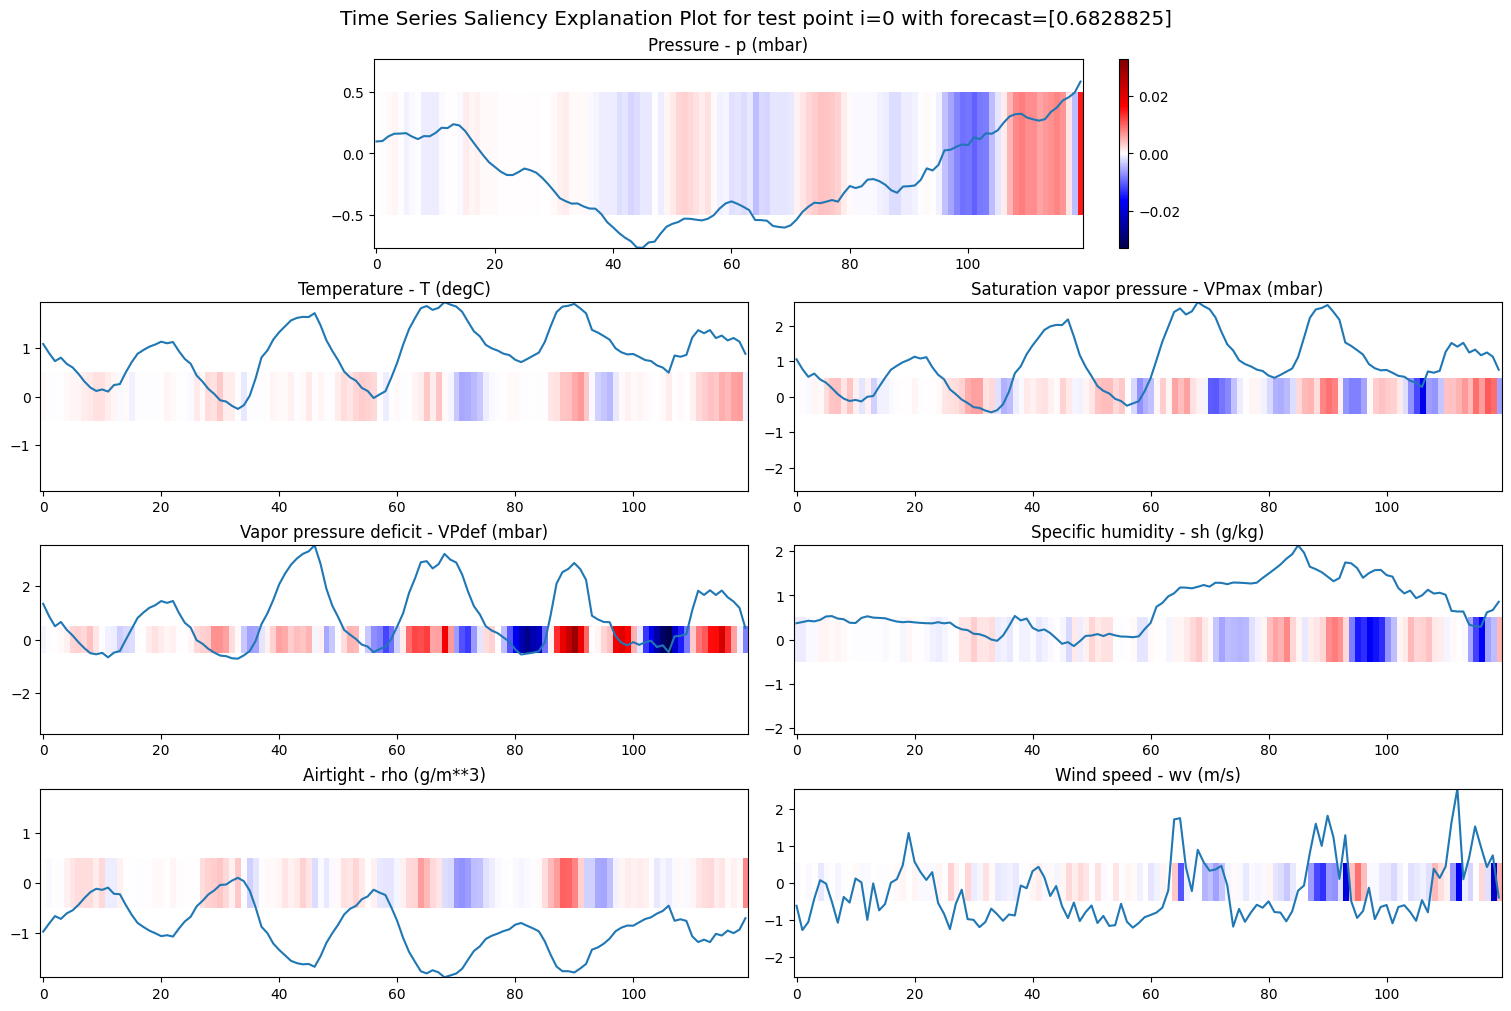

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(layout='constrained', figsize=(15,10))
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios= [1, 3], top=0.9)
gs2 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs0[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0], width_ratios=[4.5, 10, 4.5])


def plot_feature(figure, scores, feature_values, vmax, gs, title, colorbar=False):
    ax = fig.add_subplot(gs)
    offset = np.nanmean(feature_values)
    y_max = np.max([np.max(np.abs(feature_values)), vmax])
    image = ax.imshow(scores,
                      aspect='auto',
                      cmap='seismic',
                      vmin=-vmax,
                      vmax=vmax)
    ax.plot(feature_values)
    
    ax.set_ylim(top=y_max, bottom=-y_max)
    ax.set_title(title)
    if colorbar:
        plt.colorbar(mappable=image)
        
max_abs = np.max(np.abs(explanation['saliency']))
for i, feature_col in enumerate(selected_feature_columns):
    if i > 0:
        gs = gs2[i-1]
    else:
        gs = gs1[1]
        
    plot_feature(figure=fig,
                 scores=explanation['saliency'][:,i].reshape(-1, sequence_length, 1), 
                 feature_values=instance[:,i],
                 vmax=max_abs,
                 gs=gs,
                 title="{} - {}".format(selected_feature_names[i], feature_col),
                 colorbar=(i==0))

fig.suptitle("Time Series Saliency Explanation Plot for test point i={} with forecast={}".format(str(indx), str(instance_prediction)), fontsize="x-large")
plt.show()

Negative saliency score (blue colored region) implies that the model prediction changes in opposite direction as feature value changes at respective time points. Positive saliency score (red colored region) implies that the model prediction changes in same direction as feature value changes at respective time points.

From the explanation for selected point from above plot, Vapor pressure deficit has relatively more impact on the forecast, particularly in last segment of the timeseries window. Overall, last segment of the timeseries is impacting the forecast more across the features.